In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import pickle
import nltk
from datasets import load_dataset

In [3]:
# Load Turkish dataset
ds = load_dataset("kmkarakaya/turkishReviews-ds")
human_data = pd.DataFrame(ds['train'])
ai_data = pd.read_excel(r'C:\Users\halil\Downloads\AI_Complaints.xlsx') 

# Veriyi kontrol etmek için yazdır
print(ai_data.head())
print(human_data.head())


Found cached dataset parquet (C:/Users/halil/.cache/huggingface/datasets/kmkarakaya___parquet/kmkarakaya--turkishReviews-ds-af8fd3a88d6e390a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

                                                text   model  \
0  Akbank Müşteri Hizmetleri ile yaşadığım deneyi...  GPT-4o   
1  Cinemaximum’un vizyona sokulmayan filmler poli...  GPT-4o   
2  Media Markt'tan birkaç saat önce verdiğim sipa...  GPT-4o   
3  Ulusal Elektronik’ten alışveriş yapmayı kesinl...  GPT-4o   
4  Vanish Kosla kullanarak çıkarmak istediğim lek...  GPT-4o   

                                         instruction  
0                 Akbank Müşteri Hizmetleri Hakkında  
1             Cinemaximum Vizyona Sokulmayan Filmler  
2  Media Markt Birkaç Saat Önce Verilen Siparişte...  
3                 Ulusal Elektronikten Uzak Durmalı.  
4                            Vanish Kosla Leke Yaptı  
                                              review  review_length
0  Okan Üniversitesi Hastanesi'nde Çalışanların S...             45
1  Ekici Kaşar Peynirinin Peynir İle Alakası Yok....             49
2  Similac 2 Devam Sütunun İçinden Tahta Çıktı.  ...             55
3  İlhan Duma

In [4]:
print("AI Data Shape: ", ai_data.shape)
print("Human Data Shape: ", human_data.shape)
print("Human Data: ", human_data.describe())
print("Human Data Columns: ", human_data.columns)
print("Human Data Num of Words: ", human_data['review_length'].mean())
print("Human Data Max Num of Words: ", human_data['review_length'].max())
print("Human Data Min Num of Words: ", human_data['review_length'].min())


AI Data Shape:  (315, 3)
Human Data Shape:  (398772, 2)
Human Data:         review_length
count  398772.000000
mean       46.030790
std         5.291528
min        31.000000
25%        43.000000
50%        46.000000
75%        50.000000
max       183.000000
Human Data Columns:  Index(['review', 'review_length'], dtype='object')
Human Data Num of Words:  46.03078952383818
Human Data Max Num of Words:  183
Human Data Min Num of Words:  31


In [5]:
# Human datasetten review length meani değişmeyecek şekilde 10000 veri çek
human_data = human_data.sample(n=10000, random_state=42)
print("Human Data Shape: ", human_data.shape)
print("Human Data: ", human_data.describe())
print("Human Data Num of Words: ", human_data['review_length'].mean())


Human Data Shape:  (10000, 2)
Human Data:         review_length
count   10000.000000
mean       46.043500
std         5.253148
min        31.000000
25%        43.000000
50%        46.000000
75%        50.000000
max        64.000000
Human Data Num of Words:  46.0435


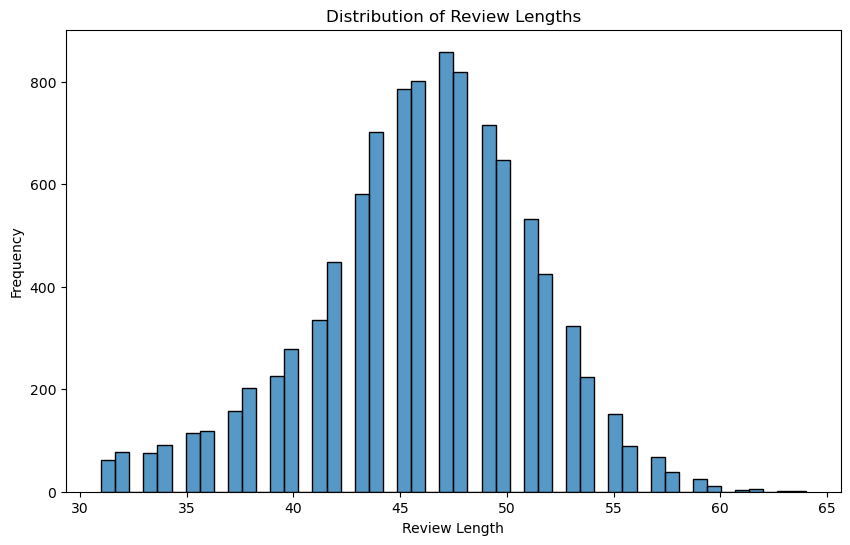

In [6]:
# Text Length Distribution
from matplotlib import pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(human_data['review_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [7]:
human_data['label'] = 'human'
human_data['text'] = human_data['review']
ai_data['label'] = 'ai'
human_data = human_data[['text', 'label']]
ai_data = ai_data[['text', 'label']]


dataset = pd.concat([human_data, ai_data], ignore_index=True)
print(dataset.head())

                                                text  label
0  Monster Notebook Garantiden Süresi Ve Çözümsüz...  human
1  Arçelik TV Ekranı İçten Kırıldı. Arçelik'ten T...  human
2  PTT Kargo Paketimi Getirmiyorlar. Ben Malatya ...  human
3  Toroslar Elektrik Dağıtım Elektrik Dalgalanmas...  human
4  Litas Hukuk Bir Borcumuz Bulunmadığı Halde Soy...  human


In [8]:
%run data_augmentation.ipynb



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\halil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\halil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Split data into training and testing sets before augmentation
train_ai_df, test_ai_df = model_selection.train_test_split(ai_data, test_size=0.3, random_state=42)

# Augment training data only
augmented_texts = []
for index, row in train_ai_df.iterrows():
    text = row['text']
    # Apply multiple transformations
    for _ in range(5):  # Repeat each transformation 5 times
        augmented_texts.append(synonym_replacement(text, n=2))
        augmented_texts.append(random_insertion(text, n=3))
        augmented_texts.append(random_swap(text, n=2))
        augmented_texts.append(random_deletion(text, p=0.1))

train_ai_augmented = pd.DataFrame(augmented_texts, columns=['text'])
train_ai_augmented['label'] = 'ai'
train_ai_augmented

,text,label
0,MESKİ'ye yönelik bir şikayetimi paylaşmak isti...,ai
1,MESKİ'ye yönelik bir şikayetimi paylaşmak isti...,ai
2,MESKİ'ye yönelik bir şikayetimi paylaşmak isti...,ai
3,MESKİ'ye yönelik bir şikayetimi paylaşmak isti...,ai
4,MESKİ'ye yönelik bir şikayetimi paylaşmak isti...,ai
...,...,...
4395,ÖSYM tarafından atanmış sınav yerimiz şehrimiz...,ai
4396,ÖSYM tarafından atanmış olan sınav yerimiz şeh...,ai
4397,ÖSYM tarafından atanmış yapılmasını olan sınav...,ai
4398,ÖSYM tarafından atanmış olan sınav yerimiz şeh...,ai


In [21]:
train_human_df, test_human_df = model_selection.train_test_split(human_data, test_size=0.3, random_state=42)

combined_train_df = pd.concat([train_ai_augmented, train_human_df], ignore_index=True)
combined_test_df = pd.concat([test_ai_df, test_human_df], ignore_index=True)
print(combined_test_df.describe())
print(combined_train_df.describe())

                                                     text  label
count                                                3095   3095
unique                                               3086      2
top     Beyaz Çamlıca Davet Salonu Kapora İadesi Yapıl...  human
freq                                                    4   3000
                                                     text  label
count                                               11400  11400
unique                                              10486      2
top     Shoppe Nikah Salonu Korona Sebebiyle Kına Orga...  human
freq                                                    6   7000


In [22]:

# Split into train and test sets
Train_X = combined_train_df['text']
Train_Y = combined_train_df['label']
Test_X = combined_test_df['text']
Test_Y = combined_test_df['label']


# Label encode the target variable
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

# Vectorize using TF-IDF
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(dataset['text'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# Train Naive Bayes
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)
print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB, Test_Y) * 100)

# Train SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf, Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Test_Y) * 100)

# Save models and vectorizers
filename = 'labelencoder_fitted.pkl'
pickle.dump(Encoder, open(filename, 'wb'))

filename = 'Tfidf_vect_fitted.pkl'
pickle.dump(Tfidf_vect, open(filename, 'wb'))

filename = 'svm_trained_model.sav'
pickle.dump(SVM, open(filename, 'wb'))

filename = 'nb_trained_model.sav'
pickle.dump(Naive, open(filename, 'wb'))

print("Files saved to disk! Proceed to inference.py")


Naive Bayes Accuracy Score ->  99.67689822294022
SVM Accuracy Score ->  99.90306946688207
Files saved to disk! Proceed to inference.py


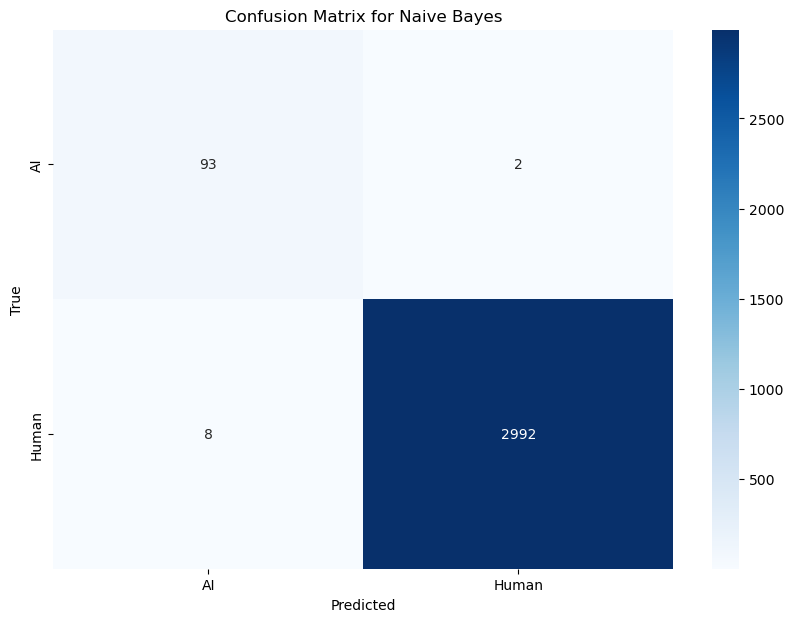

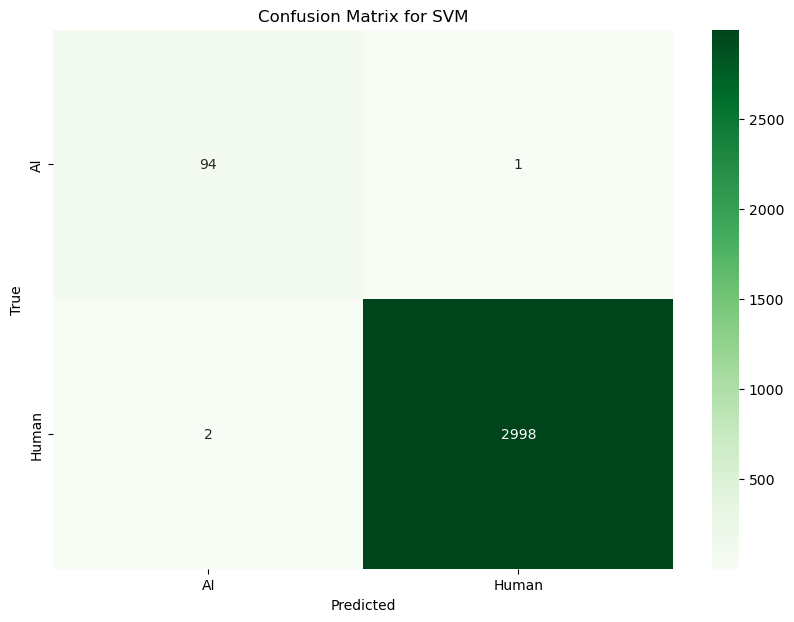

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix for Naive Bayes
cm_NB = confusion_matrix(Test_Y, predictions_NB)
plt.figure(figsize=(10,7))
sns.heatmap(cm_NB, annot=True, fmt='d', cmap="Blues", xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion Matrix for SVM
cm_SVM = confusion_matrix(Test_Y, predictions_SVM)
plt.figure(figsize=(10,7))
sns.heatmap(cm_SVM, annot=True, fmt='d', cmap="Greens", xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
